In [431]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn import preprocessing

import xgboost as xgb
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin

In [432]:
dados = pd.read_csv("dados_pre_processados.csv")
dados.drop("Unnamed: 0", axis = "columns", inplace=True)
dados.head()

,CodigoReceita,Volume,TipoLancamento,DataEmissaoNotaFiscal,CodigoCliente,CodigoMotorista,TempoPermanenciaObra,ConsumoTotal,Idade,TipoTraco,CodigoAglomerante,FCK,Rompimento7Dias,Rompimento28Dias,ConsumoPorM3,DesvioAplicado,ResultadoProjetado,PercentualCrescimentoReal,PercentualCrescimentoProjetado,RelacaoAguaCimento
0,672051,8.0,B,2015-01-16 07:35:31.770,6248051,11080,02:41:00,2.720.000,28,N,12051.0,30.0,20.83,31.81,340.0,3.5,33.321754,52.712434,59.970014,0.535294
1,672051,8.0,B,2015-01-16 08:20:03.153,6248051,87079,02:46:00,2.720.000,28,N,12051.0,30.0,19.62,31.21,340.0,3.5,31.799067,59.072375,62.074756,0.535294
2,672051,7.0,B,2015-01-16 10:05:20.293,6248051,43080,01:32:00,2.380.000,28,N,12051.0,30.0,21.97,36.68,340.0,3.5,34.733698,66.954939,58.096029,0.535294
3,672051,8.0,B,2015-01-20 18:52:57.373,12343051,43080,01:10:00,2.720.000,28,N,12051.0,30.0,28.21,40.21,340.0,3.5,42.118539,42.538107,49.303577,0.535294
4,672051,6.0,B,2015-01-21 07:08:54.847,6248051,42080,00:35:00,2.040.000,28,N,12051.0,30.0,25.80,38.74,340.0,3.5,39.330637,50.155039,52.444329,0.535294


In [433]:
#dados_por_aglomerante = dados.groupby("CodigoAglomerante")
#dados_por_aglomerante.groups.keys()

In [434]:
#da = dados_por_aglomerante.get_group(11051.0)
#da.head()

In [435]:
def EncontrarDataProjecao(item):
    dataEmissao = pd.to_datetime(item["DataEmissaoNotaFiscal"])    
    diaDaSemana = dataEmissao.weekday()
    
    diasDeAdicao = 0
    
    if (diaDaSemana == 0):
        diasDeAdicao = 4
    elif (diaDaSemana == 1):
        diasDeAdicao = 3
    elif (diaDaSemana == 2):
        diasDeAdicao = 2
    elif (diaDaSemana == 3):
        diasDeAdicao = 1
    elif (diaDaSemana == 4):
        diasDeAdicao = 0
    elif (diaDaSemana == 5):
        diasDeAdicao = 6
    else:
        diasDeAdicao = 5
        
    dataProjecao = dataEmissao + dt.timedelta(days=diasDeAdicao)
    return dataProjecao.date()

In [436]:
dados["DataProjecao"] = dados.apply(EncontrarDataProjecao, axis = "columns")

In [437]:
dados = dados.sort_values("DataProjecao")
dados.head()

,CodigoReceita,Volume,TipoLancamento,DataEmissaoNotaFiscal,CodigoCliente,CodigoMotorista,TempoPermanenciaObra,ConsumoTotal,Idade,TipoTraco,...,FCK,Rompimento7Dias,Rompimento28Dias,ConsumoPorM3,DesvioAplicado,ResultadoProjetado,PercentualCrescimentoReal,PercentualCrescimentoProjetado,RelacaoAguaCimento,DataProjecao
2447,5006051,5.0,C,2015-01-08 10:18:19.693,94820051,702051,01:05:00,1.075.000,28,N,...,20.0,17.15,25.46,215.0,2.5,27.845988,48.454810,62.367279,0.716279,2015-01-09
2308,20823051,7.0,C,2015-01-09 14:50:27.520,13639051,11080,00:45:00,2.114.000,28,N,...,30.0,22.20,32.97,302.0,6.5,33.705596,48.513514,51.827010,0.523179,2015-01-09
2320,20848051,7.0,C,2015-01-07 13:20:25.370,13416051,342051,01:00:00,2.037.000,28,N,...,25.0,19.60,29.36,291.0,6.0,30.549117,49.795918,55.862842,0.577320,2015-01-09
2321,493051,7.0,B,2015-01-07 13:57:15.470,11625051,37079,01:41:00,1.477.000,28,N,...,15.0,11.89,18.01,211.0,4.0,20.388990,51.471825,71.480151,0.753555,2015-01-09
2338,21067051,5.0,B,2015-01-07 15:19:35.657,91006051,13148,02:23:00,1.600.000,28,E,...,25.0,20.29,32.65,320.0,NaN,31.397121,60.916708,54.741848,0.503125,2015-01-09


In [635]:
def ObtemDadosParaAnalise(data_projecao, dados):
    data_inicio_busca_dados = data_projecao - dt.timedelta(weeks=12)
    data_fim_busca_dados = data_projecao - dt.timedelta(weeks=4)

    mask_data_inicio_busca_dados = da["DataProjecao"] >= data_inicio_busca_dados
    mask_data_fim_busca_dados = da["DataProjecao"] <= data_fim_busca_dados
    
    indices = da[mask_data_inicio_busca_dados & mask_data_fim_busca_dados].index
    #indices = da[mask_data_fim_busca_dados].index
    
    retorno = dados.loc[indices]
    
    retorno = RemoveOutliers(retorno, "Rompimento7Dias")
    retorno = RemoveOutliers(retorno, "Rompimento28Dias")
    #retorno = RemoveOutliers(retorno, "RelacaoAguaCimento")
    
    return retorno

def ObtemDadosPesoMaior(data_projecao, dados):
    data_inicio_busca_dados = data_projecao - dt.timedelta(weeks=6)
    data_fim_busca_dados = data_projecao - dt.timedelta(weeks=4)

    mask_data_inicio_busca_dados = da["DataProjecao"] >= data_inicio_busca_dados
    mask_data_fim_busca_dados = da["DataProjecao"] <= data_fim_busca_dados
    
    indices = da[mask_data_inicio_busca_dados & mask_data_fim_busca_dados].index
    
    return dados.loc[indices]

def ObtemDadosTeste(data_projecao, dados):
    mask_data_projecao = da["DataProjecao"] == data_projecao
    
    indices = da[mask_data_projecao].index
    
    retorno = dados.loc[indices]
    
    #retorno = RemoveOutliers(retorno, "Rompimento7Dias")
    #retorno = RemoveOutliers(retorno, "Rompimento28Dias")
    #retorno = RemoveOutliers(retorno, "RelacaoAguaCimento")
    
    return retorno

def CalculaMediaMpaAcimaAnalise(data_projecao, dados):
    dados_cheios = ObtemDadosParaAnalise(data_projecao, dados)
    
    mpaAcimaMedio = CalcularMediaMpaAcima(dados_cheios, "Rompimento28Dias")
    return mpaAcimaMedio

def CalculaMediaMpaAcimaTeste(data_projecao, dados, y_pred):
    dados_cheios = ObtemDadosTeste(data_projecao, dados)
    
    mpaAcimaMedio = CalcularMediaMpaAcimaPredito(dados_cheios, y_pred)
    return mpaAcimaMedio
    
def CalculaMediaMpaAcimaProjetado(data_projecao, dados):
    dados_cheios = ObtemDadosTeste(data_projecao, dados)
    
    mpaAcimaMedio = CalcularMediaMpaAcima(dados_cheios, "ResultadoProjetado")
    return mpaAcimaMedio
    
def CalcularMediaMpaAcima(dados, colunaRompimento28):
    mpaAcimaxVolume = 0
    volumeTotal = 0

    for i in range(0, len(dados)):
        volume = dados.iloc[i]["Volume"]        
        rompimento28Dias = dados.iloc[i][colunaRompimento28]
        fck = dados.iloc[i]["FCK"]
        mpaAcima = rompimento28Dias - fck
        
        mpaAcimaxVolume = mpaAcimaxVolume + (mpaAcima * volume)
        volumeTotal = volumeTotal + dados.iloc[i]["Volume"]
        
    return mpaAcimaxVolume/volumeTotal


def CalcularMediaMpaAcimaPredito(dados, y_pred):
    mpaAcimaxVolume = 0
    volumeTotal = 0

    for i in range(0, len(dados)):
        volume = dados.iloc[i]["Volume"]        
        rompimento28Dias = y_pred[i]
        fck = dados.iloc[i]["FCK"]
        mpaAcima = rompimento28Dias - fck
        
        mpaAcimaxVolume = mpaAcimaxVolume + (mpaAcima * volume)
        volumeTotal = volumeTotal + dados.iloc[i]["Volume"]
        
    return mpaAcimaxVolume/volumeTotal

def RemoveOutliers(dados, coluna):
    q1 = dados[coluna].quantile(0.25)
    q3 = dados[coluna].quantile(0.75)
    iqr = q3 - q1

    print(len(dados))
    
    maskOutlier = (dados[coluna] < (q1 - 1.5 * iqr)) | (dados[coluna] > (q3 + 1.5 * iqr))
    retorno = dados[maskOutlier == False]
    
    print("Sem outlier:",len(retorno))
    return retorno

In [597]:
dados = dados[dados["DesvioAplicado"].notna()]
dados = dados[dados["Volume"] > 0]
dados.head()

,CodigoReceita,Volume,TipoLancamento,DataEmissaoNotaFiscal,CodigoCliente,CodigoMotorista,TempoPermanenciaObra,ConsumoTotal,Idade,TipoTraco,CodigoAglomerante,FCK,Rompimento7Dias,Rompimento28Dias,ConsumoPorM3,DesvioAplicado,ResultadoProjetado,PercentualCrescimentoReal,PercentualCrescimentoProjetado,RelacaoAguaCimento,DataProjecao
2447,5006051,5.0,0,2015-01-08 10:18:19.693,94820051,702051,01:05:00,1.075.000,28,0,25051.0,20.0,17.15,25.46,215.0,2.5,27.845988,48.454810,62.367279,0.716279,2015-01-09
2308,20823051,7.0,0,2015-01-09 14:50:27.520,13639051,11080,00:45:00,2.114.000,28,0,57051.0,30.0,22.20,32.97,302.0,6.5,33.705596,48.513514,51.827010,0.523179,2015-01-09
2320,20848051,7.0,0,2015-01-07 13:20:25.370,13416051,342051,01:00:00,2.037.000,28,0,57051.0,25.0,19.60,29.36,291.0,6.0,30.549117,49.795918,55.862842,0.577320,2015-01-09
2321,493051,7.0,1,2015-01-07 13:57:15.470,11625051,37079,01:41:00,1.477.000,28,0,3051.0,15.0,11.89,18.01,211.0,4.0,20.388990,51.471825,71.480151,0.753555,2015-01-09
2352,13258051,8.0,1,2015-01-08 07:11:10.983,6680051,727051,00:45:00,2.640.000,28,0,14051.0,25.0,27.00,36.01,330.0,4.0,36.620758,33.370370,35.632439,0.603030,2015-01-09


In [598]:
#da2 = da[["CodigoReceita", "TipoLancamento", "TipoTraco", "FCK", "RelacaoAguaCimento", "ConsumoPorM3", "DesvioAplicado", "Rompimento7Dias", "PercentualCrescimentoProjetado", "PercentualCrescimentoReal"]]
#da2 = dados[["TipoLancamento", "TipoTraco", "FCK", "RelacaoAguaCimento", "Rompimento7Dias", "ResultadoProjetado", "Rompimento28Dias"]]

dados["TipoLancamento"].replace('C', 0, inplace = True)
dados["TipoLancamento"].replace('B', 1, inplace = True)

dados["TipoTraco"].replace('N', 0, inplace = True)
dados["TipoTraco"].replace('E', 1, inplace = True)

#da2.columns = ['CodigoReceita', 'EhLancamentoBombeavel', 'EhTracoEspecial', 'FCK', 'RelacaoAguaCimento',
#       "ConsumoPorM3", "DesvioAplicado", 'Rompimento7Dias', 'PercentualCrescimentoProjetado', 'PercentualCrescimentoReal']
#da2.columns = ['EhLancamentoBombeavel', 'EhTracoEspecial', 'FCK',
#       "RelacaoAguaCimento", 'Rompimento7Dias', 'ResultadoProjetado', 'Rompimento28Dias']


In [626]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):        
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class Debug(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):        
        print(X)

modelo = Pipeline([
  ('features', FeatureUnion(
      transformer_list=[
          ('numericals', Pipeline([
              ('selector', TypeSelector(np.number)),
              ('scaler', MinMaxScaler())
          ]))
      ]
  )),
  ('model', GradientBoostingRegressor(learning_rate = 0.5, random_state = 1))
    #('model', DecisionTreeRegressor())
    ('model', xgb.XGBRegressor())
])

In [627]:
aglomerantes = []
perc_geral = []
total_projecoes = []

dados_por_aglomerante = dados.groupby("CodigoAglomerante")
codigosAglomerante = dados_por_aglomerante.groups.keys()

print(codigosAglomerante)

for codigoAglomerante in codigosAglomerante:
    
    aglomerantes.append(codigoAglomerante)
    
    print(codigoAglomerante)
    
    da = dados_por_aglomerante.get_group(codigoAglomerante)
    
    da2 = da[["TipoLancamento", "TipoTraco", "FCK", "RelacaoAguaCimento", "Rompimento7Dias", "ResultadoProjetado", "Rompimento28Dias"]]
    da2.columns = ['EhLancamentoBombeavel', 'EhTracoEspecial', 'FCK', "RelacaoAguaCimento", 'Rompimento7Dias', 'ResultadoProjetado', 'Rompimento28Dias']
    
    data_projecao_inicio = da.head(1)["DataProjecao"].values[0]
    data_projecao_fim = da.tail(1)["DataProjecao"].values[0]
    data_projecao = data_projecao_inicio + dt.timedelta(weeks=24)
    
    data_projecao_atual = data_projecao

    datas_projecao = []
    listaMpaAcimaReal = []
    listaMpaAcimaProj = []
    listaMpaAcimaPred = []
    mais_prox = []
    quantidade_dados_analise = []
    quantidade_dados_teste = []
    
    while (data_projecao_atual <= data_projecao_fim):
        dados_analise = ObtemDadosParaAnalise(data_projecao_atual, da2)    
        dados_teste = ObtemDadosTeste(data_projecao_atual, da2)

        if (len(dados_analise) < 10):
            data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)
            continue
        elif (len(dados_teste) == 0):
            data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)
            continue
        else:
            quantidade_dados_analise.append(len(dados_analise))
            quantidade_dados_teste.append(len(dados_teste))

            x_train = dados_analise.drop(["ResultadoProjetado", "Rompimento28Dias"], axis=1)
            y_train = dados_analise["Rompimento28Dias"]

            x_test = dados_teste.drop(["ResultadoProjetado", "Rompimento28Dias"], axis=1)
            y_test = dados_teste["Rompimento28Dias"]

            pesos = np.ones(len(dados_analise))

            dados_peso_maior = ObtemDadosPesoMaior(data_projecao_atual, da2)
            quantidade_peso_maior = len(dados_peso_maior)

            pesos[-quantidade_peso_maior:]*= 1.1

            modelo.fit(x_train, y_train, **{'model__sample_weight': pesos})
            #modelo.fit(x_train, y_train)
            y_pred = modelo.predict(x_test)        
            y_proj = dados_teste["ResultadoProjetado"]

            mpaAcimaProj = CalculaMediaMpaAcimaProjetado(data_projecao_atual, da)
            mpaAcimaPred = CalculaMediaMpaAcimaTeste(data_projecao_atual, da, y_pred)
            mpaAcimaReal = CalculaMediaMpaAcimaAnalise(data_projecao_atual, da)

            listaMpaAcimaReal.append(mpaAcimaReal)
            listaMpaAcimaProj.append(mpaAcimaProj)
            listaMpaAcimaPred.append(mpaAcimaPred)

            diff_real_proj = abs(mpaAcimaProj - mpaAcimaReal)
            diff_real_pred = abs(mpaAcimaPred - mpaAcimaReal)

            datas_projecao.append(data_projecao_atual)

            if (diff_real_proj <= diff_real_pred):
                mais_prox.append('ModeloVelho')
            else:
                mais_prox.append('ModeloNovo')

            data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)
            
    dados_resultado = pd.DataFrame(columns = ["MPaAcimaMedioMaisProx"])
    dados_resultado["MPaAcimaMedioMaisProx"] = mais_prox
    
    modelo_novo_melhor = len(dados_resultado[dados_resultado["MPaAcimaMedioMaisProx"] == "ModeloNovo"])
    todos_dados = len(dados_resultado)
    
    total_projecoes.append(todos_dados)

    if(todos_dados > 0):
        perc = modelo_novo_melhor * 100/todos_dados
    else:
        perc = 0

    perc_geral.append(perc)

dict_keys([3051.0, 4051.0, 7051.0, 10051.0, 11051.0, 12051.0, 13051.0, 14051.0, 15051.0, 17051.0, 18051.0, 24051.0, 25051.0, 28051.0, 29051.0, 41051.0, 42051.0, 44051.0, 45051.0, 46051.0, 55051.0, 56051.0, 57051.0, 58051.0, 59051.0, 60051.0, 61051.0, 62051.0, 63051.0, 64051.0, 65051.0, 66051.0, 67051.0, 68051.0, 69051.0, 70051.0, 71051.0, 72051.0, 74051.0, 75051.0, 77051.0, 78051.0, 79051.0, 81051.0, 82051.0, 83051.0, 84051.0, 85051.0, 88051.0, 91051.0, 92051.0, 93051.0, 94051.0, 95051.0, 96051.0, 106051.0, 107051.0, 108051.0, 109051.0, 111051.0, 112051.0, 113051.0, 114051.0, 115051.0, 116051.0, 117051.0, 118051.0, 119051.0, 120051.0, 122051.0])
3051.0


KeyboardInterrupt: 

In [ ]:
len(perc_geral)

In [594]:
dados_aglomerante = pd.DataFrame(columns = ["Aglomerante", "PercentualAcerto", "QtdDados"])

dados_aglomerante["Aglomerante"] = aglomerantes
dados_aglomerante["PercentualAcerto"] = perc_geral
dados_aglomerante["QtdDados"] = total_projecoes

In [595]:
dados_aglomerante.sort_values(by = "PercentualAcerto", ascending = False).head(30)

,Aglomerante,PercentualAcerto,QtdDados
41,78051.0,100.000000,6
56,107051.0,100.000000,4
30,65051.0,92.857143,14
53,95051.0,88.888889,9
68,120051.0,84.615385,13
0,3051.0,75.757576,33
59,111051.0,75.000000,12
58,109051.0,74.193548,31
7,14051.0,73.076923,52
65,117051.0,72.727273,11


In [608]:
da = dados_por_aglomerante.get_group(75051.0)

da2 = da[["TipoLancamento", "TipoTraco", "FCK", "RelacaoAguaCimento", "Rompimento7Dias", "ResultadoProjetado", "Rompimento28Dias"]]
da2.columns = ['EhLancamentoBombeavel', 'EhTracoEspecial', 'FCK', "RelacaoAguaCimento", 'Rompimento7Dias', 'ResultadoProjetado', 'Rompimento28Dias']

data_projecao_inicio = da.head(1)["DataProjecao"].values[0]
data_projecao_fim = da.tail(1)["DataProjecao"].values[0]
data_projecao = data_projecao_inicio + dt.timedelta(weeks=24)

data_projecao_atual = data_projecao

datas_projecao = []
listaMpaAcimaReal = []
listaMpaAcimaProj = []
listaMpaAcimaPred = []
mais_prox = []
quantidade_dados_analise = []
quantidade_dados_teste = []

while (data_projecao_atual <= data_projecao_fim):
    dados_analise = ObtemDadosParaAnalise(data_projecao_atual, da2)    
    dados_teste = ObtemDadosTeste(data_projecao_atual, da2)

    if (len(dados_analise) < 10):
        data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)
        continue
    elif (len(dados_teste) == 0):
        data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)
        continue
    else:
        quantidade_dados_analise.append(len(dados_analise))
        quantidade_dados_teste.append(len(dados_teste))

        x_train = dados_analise.drop(["ResultadoProjetado", "Rompimento28Dias"], axis=1)
        y_train = dados_analise["Rompimento28Dias"]

        x_test = dados_teste.drop(["ResultadoProjetado", "Rompimento28Dias"], axis=1)
        y_test = dados_teste["Rompimento28Dias"]

        pesos = np.ones(len(dados_analise))

        dados_peso_maior = ObtemDadosPesoMaior(data_projecao_atual, da2)
        quantidade_peso_maior = len(dados_peso_maior)

        pesos[-quantidade_peso_maior:]*= 1.1

        modelo.fit(x_train, y_train, **{'model__sample_weight': pesos})
        #modelo.fit(x_train, y_train)
        y_pred = modelo.predict(x_test)        
        y_proj = dados_teste["ResultadoProjetado"]

        mpaAcimaProj = CalculaMediaMpaAcimaProjetado(data_projecao_atual, da)
        mpaAcimaPred = CalculaMediaMpaAcimaTeste(data_projecao_atual, da, y_pred)
        mpaAcimaReal = CalculaMediaMpaAcimaAnalise(data_projecao_atual, da)

        listaMpaAcimaReal.append(mpaAcimaReal)
        listaMpaAcimaProj.append(mpaAcimaProj)
        listaMpaAcimaPred.append(mpaAcimaPred)

        diff_real_proj = abs(mpaAcimaProj - mpaAcimaReal)
        diff_real_pred = abs(mpaAcimaPred - mpaAcimaReal)

        datas_projecao.append(data_projecao_atual)

        if (diff_real_proj < diff_real_pred):
            mais_prox.append('ModeloVelho')
        elif (diff_real_proj > diff_real_pred):
            mais_prox.append('ModeloNovo')
        else:
            mais_prox.append('ModeloNovo')

        data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)

In [609]:
dados_resultado = pd.DataFrame(columns = ["DataProjecao", "MPaAcimaMedioReal", "MPaAcimaMedioProj", "MPaAcimaMedioPred", "MPaAcimaMedioMaisProx", "QtdDadosAnalise", "QtdDadosTeste"])

dados_resultado["DataProjecao"] = datas_projecao
dados_resultado["MPaAcimaMedioReal"] = listaMpaAcimaReal
dados_resultado["MPaAcimaMedioProj"] = listaMpaAcimaProj
dados_resultado["MPaAcimaMedioPred"] = listaMpaAcimaPred
dados_resultado["MPaAcimaMedioMaisProx"] = mais_prox
dados_resultado["QtdDadosAnalise"] = quantidade_dados_analise
dados_resultado["QtdDadosTeste"] = quantidade_dados_teste

#dados_resultados_com_teste = dados_resultado[dados_resultado["QtdDadosTeste"] > 10]
dados_resultados_com_teste = dados_resultado

dados_resultados_com_teste

,DataProjecao,MPaAcimaMedioReal,MPaAcimaMedioProj,MPaAcimaMedioPred,MPaAcimaMedioMaisProx,QtdDadosAnalise,QtdDadosTeste
0,2017-10-20,14.068333,7.649633,11.605219,ModeloNovo,12,19
1,2017-10-27,12.485325,6.745581,6.756324,ModeloNovo,12,12
2,2017-11-17,9.346417,3.834552,9.893913,ModeloNovo,19,1
3,2017-11-24,7.763827,3.817159,6.185963,ModeloNovo,28,1
4,2017-12-15,8.805179,1.971203,6.502580,ModeloNovo,60,2
5,2017-12-29,8.579111,-1.821357,2.362297,ModeloNovo,58,1
6,2018-01-05,8.579111,2.086315,5.800405,ModeloNovo,58,11
7,2018-01-12,8.579111,1.256008,4.424023,ModeloNovo,58,4
8,2018-01-26,8.915842,2.018553,2.627987,ModeloNovo,28,2
9,2018-03-09,4.725862,14.748961,7.552810,ModeloNovo,15,5


In [610]:
modelo_novo_melhor = len(dados_resultados_com_teste[dados_resultados_com_teste["MPaAcimaMedioMaisProx"] == "ModeloNovo"])
todos_dados = len(dados_resultados_com_teste)

print("modelo foi melhor em", modelo_novo_melhor)
print("total", todos_dados)

perc = modelo_novo_melhor * 100/todos_dados

print("Percentual:", perc)

modelo foi melhor em 30
total 41
Percentual: 73.17073170731707


In [517]:
da.head()

,CodigoReceita,Volume,TipoLancamento,DataEmissaoNotaFiscal,CodigoCliente,CodigoMotorista,TempoPermanenciaObra,ConsumoTotal,Idade,TipoTraco,...,FCK,Rompimento7Dias,Rompimento28Dias,ConsumoPorM3,DesvioAplicado,ResultadoProjetado,PercentualCrescimentoReal,PercentualCrescimentoProjetado,RelacaoAguaCimento,DataProjecao
38008,33488051,6.0,1,2017-03-08 14:43:53.140,133258051,812051,00:54:00,2.172.000,28,0,...,30.0,25.73,35.08,362.0,6.0,35.882105,36.338904,39.456298,0.538674,2017-03-10
38106,33541051,6.0,1,2017-03-24 12:13:31.350,12560051,173051,00:18:00,2.124.000,28,0,...,30.0,23.26,30.93,354.0,6.0,32.951628,32.975064,41.666500,0.533898,2017-03-24
38107,33541051,6.0,1,2017-03-24 13:21:38.870,12560051,94079,00:30:00,2.124.000,28,0,...,30.0,22.32,31.90,354.0,6.0,31.821606,42.921147,42.569919,0.528249,2017-03-24
38108,33541051,7.0,1,2017-03-29 07:34:41.580,12560051,66079,00:32:00,2.478.000,28,0,...,30.0,23.09,31.30,354.0,6.0,32.747889,35.556518,41.827148,0.533898,2017-03-31
38110,33541051,7.0,1,2017-03-29 09:19:57.647,12560051,727051,00:22:00,2.478.000,28,0,...,30.0,23.24,31.02,354.0,6.0,32.927673,33.476764,41.685339,0.533898,2017-03-31


In [636]:
da = dados_por_aglomerante.get_group(75051.0)

da2 = da[["Rompimento7Dias", "ResultadoProjetado", "Rompimento28Dias"]]
da2.columns = ['Rompimento7Dias', 'ResultadoProjetado', 'Rompimento28Dias']

data_projecao_inicio = da.head(1)["DataProjecao"].values[0]
data_projecao_fim = da.tail(1)["DataProjecao"].values[0]
data_projecao = data_projecao_inicio + dt.timedelta(weeks=24)

data_projecao_atual = data_projecao

datas_projecao = []
perc_acerto = []
quantidade_dados_analise = []
quantidade_dados_teste = []

while (data_projecao_atual <= data_projecao_fim):
    dados_analise = ObtemDadosParaAnalise(data_projecao_atual, da2)    
    dados_teste = ObtemDadosTeste(data_projecao_atual, da2)

    if (len(dados_analise) < 10):
        data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)
        continue
    elif (len(dados_teste) == 0):
        data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)
        continue
    else:
        quantidade_dados_analise.append(len(dados_analise))
        quantidade_dados_teste.append(len(dados_teste))

        x_train = dados_analise.drop(["ResultadoProjetado", "Rompimento28Dias"], axis=1)
        y_train = dados_analise["Rompimento28Dias"]

        x_test = dados_teste.drop(["ResultadoProjetado", "Rompimento28Dias"], axis=1)
        y_test = dados_teste["Rompimento28Dias"]

        pesos = np.ones(len(dados_analise))

        dados_peso_maior = ObtemDadosPesoMaior(data_projecao_atual, da2)
        quantidade_peso_maior = len(dados_peso_maior)

        pesos[-quantidade_peso_maior:]*= 1.1

        #modelo.fit(x_train, y_train, **{'model__sample_weight': pesos})
        modelo.fit(x_train, y_train)
        y_pred = modelo.predict(x_test)        
        y_proj = dados_teste["ResultadoProjetado"]

        j = 0
        resultado_final = []

        for i in y_test.index:
            diff_real_proj = (y_test[i] - y_proj[i])/y_test[i]
            diff_real_pred = (y_test[i] - y_pred[j])/y_test[i]

            if (diff_real_proj <= diff_real_pred):
                resultado_final.append('ModeloAntigo')
            else:
                resultado_final.append('ModeloNovo')

            j = j + 1
            
        perc_acerto_por_data_projecao = resultado_final.count('ModeloNovo') / (resultado_final.count('ModeloNovo') + resultado_final.count('ModeloAntigo'))

        datas_projecao.append(data_projecao_atual)
        perc_acerto.append(perc_acerto_por_data_projecao)

        data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)

16
Sem outlier: 16
16
Sem outlier: 16
28
Sem outlier: 28
28
Sem outlier: 28
29
Sem outlier: 29
29
Sem outlier: 29
29
Sem outlier: 29
29
Sem outlier: 29
27
Sem outlier: 27
27
Sem outlier: 26
24
Sem outlier: 24
24
Sem outlier: 24
15
Sem outlier: 14
14
Sem outlier: 13
15
Sem outlier: 14
14
Sem outlier: 13
15
Sem outlier: 14
14
Sem outlier: 13
13
Sem outlier: 13
13
Sem outlier: 13
1
Sem outlier: 1
1
Sem outlier: 1
0
Sem outlier: 0
0
Sem outlier: 0
19
Sem outlier: 19
19
Sem outlier: 19
31
Sem outlier: 30
30
Sem outlier: 28
44
Sem outlier: 43
43
Sem outlier: 40
60
Sem outlier: 60
60
Sem outlier: 60
61
Sem outlier: 61
61
Sem outlier: 60
62
Sem outlier: 62
62
Sem outlier: 59
62
Sem outlier: 62
62
Sem outlier: 59
62
Sem outlier: 62
62
Sem outlier: 59
64
Sem outlier: 64
64
Sem outlier: 61
45
Sem outlier: 45
45
Sem outlier: 43
34
Sem outlier: 34
34
Sem outlier: 31
32
Sem outlier: 32
32
Sem outlier: 32
20
Sem outlier: 20
20
Sem outlier: 20
19
Sem outlier: 19
19
Sem outlier: 19
20
Sem outlier: 20
2

In [632]:
dados_resultado = pd.DataFrame(columns = ["DataProjecao", "PercAcertoModeloNovo", "QuantidadeDadosTeste"])

dados_resultado["DataProjecao"] = datas_projecao
dados_resultado["PercAcertoModeloNovo"] = perc_acerto
dados_resultado["QuantidadeDadosTeste"] = quantidade_dados_teste

In [633]:
mask_melhor_modelo_novo = dados_resultado["PercAcertoModeloNovo"] >= 0.5

print("Modelo novo foi melhor em", len(dados_resultado[mask_melhor_modelo_novo]), " de", len(dados_resultado))

dados_resultado

Modelo novo foi melhor em 19  de 41


,DataProjecao,PercAcertoModeloNovo,QuantidadeDadosTeste
0,2017-10-20,0.894737,19
1,2017-10-27,0.666667,12
2,2017-11-17,1.000000,1
3,2017-11-24,1.000000,1
4,2017-12-15,1.000000,2
5,2017-12-29,1.000000,1
6,2018-01-05,1.000000,11
7,2018-01-12,0.750000,4
8,2018-01-26,0.500000,2
9,2018-03-09,0.200000,5


In [569]:
da_esp = da[da["DataProjecao"] == dt.date(2018, 11, 30)]
da_esp.head()

,CodigoReceita,Volume,TipoLancamento,DataEmissaoNotaFiscal,CodigoCliente,CodigoMotorista,TempoPermanenciaObra,ConsumoTotal,Idade,TipoTraco,CodigoAglomerante,FCK,Rompimento7Dias,Rompimento28Dias,ConsumoPorM3,DesvioAplicado,ResultadoProjetado,PercentualCrescimentoReal,PercentualCrescimentoProjetado,RelacaoAguaCimento,DataProjecao
43787,37839051,8.0,1,2018-11-30 08:19:01.823,8809051,66079,00:25:00,2.720.000,28,0,75051.0,30.0,32.61,37.54,340.0,6.0,40.777279,15.118062,25.045320,0.591176,2018-11-30
43933,37949051,7.0,1,2018-11-30 11:48:55.177,680561998,94079,00:45:00,2.737.000,28,1,75051.0,25.0,30.72,37.04,391.0,7.0,40.291244,20.572917,31.156395,0.537084,2018-11-30
43788,37839051,8.0,1,2018-11-30 10:38:18.167,8809051,105079,00:23:00,2.720.000,28,0,75051.0,30.0,32.56,39.44,340.0,6.0,40.723699,21.130221,25.072787,0.597059,2018-11-30
42533,37260051,5.0,1,2018-11-26 09:50:31.987,77776998,911051,00:25:00,1.375.000,28,0,75051.0,25.0,29.05,38.75,275.0,6.0,36.926782,33.390706,27.114569,0.509091,2018-11-30
42532,37260051,6.0,1,2018-11-26 09:12:47.273,77776998,727051,00:40:00,1.650.000,28,0,75051.0,25.0,24.43,34.70,275.0,6.0,31.811517,42.038477,30.214967,0.509091,2018-11-30


In [555]:
da["FCK"].value_counts()

25.0    220
30.0    157
20.0     47
35.0     34
15.0      8
Name: FCK, dtype: int64

In [556]:
da["TipoTraco"].value_counts()

0    361
1    105
Name: TipoTraco, dtype: int64

In [557]:
mask_fck = da["FCK"] == 25
mask_tipo_traco = da["TipoTraco"] == 0

da_fck_esp = da[mask_fck & mask_tipo_traco]
da_fck_esp.head()

,CodigoReceita,Volume,TipoLancamento,DataEmissaoNotaFiscal,CodigoCliente,CodigoMotorista,TempoPermanenciaObra,ConsumoTotal,Idade,TipoTraco,...,FCK,Rompimento7Dias,Rompimento28Dias,ConsumoPorM3,DesvioAplicado,ResultadoProjetado,PercentualCrescimentoReal,PercentualCrescimentoProjetado,RelacaoAguaCimento,DataProjecao
39423,34644051,7.0,0,2017-07-04 12:47:59.280,11129051,54079,01:26:00,2.044.000,28,0,...,25.0,26.57,36.56,292.0,6.0,31.414963,37.598796,18.234713,0.537671,2017-07-07
39427,34650051,8.0,1,2017-07-05 08:12:15.767,154417998,66079,00:45:00,2.312.000,28,0,...,25.0,22.89,26.77,289.0,6.0,28.118389,16.950633,22.841366,0.570934,2017-07-07
39429,34650051,8.0,1,2017-07-05 10:40:02.847,154417998,173051,01:20:00,2.312.000,28,0,...,25.0,17.81,26.67,289.0,6.0,23.259043,49.747333,30.595413,0.570934,2017-07-07
39428,34650051,8.0,1,2017-07-05 10:18:18.700,154417998,226051,00:28:00,2.312.000,28,0,...,25.0,16.88,24.99,289.0,6.0,22.324239,48.045024,32.252599,0.570934,2017-07-07
40103,34905051,8.0,0,2017-08-03 14:54:29.060,200789998,517051,02:18:00,2.224.000,28,0,...,25.0,22.14,29.67,278.0,6.0,27.424990,34.010840,23.870775,0.535971,2017-08-04


In [558]:
da_fck_esp.describe()

,CodigoReceita,Volume,TipoLancamento,CodigoCliente,CodigoMotorista,Idade,TipoTraco,CodigoAglomerante,FCK,Rompimento7Dias,Rompimento28Dias,ConsumoPorM3,DesvioAplicado,ResultadoProjetado,PercentualCrescimentoReal,PercentualCrescimentoProjetado,RelacaoAguaCimento
count,1.830000e+02,183.000000,183.000000,1.830000e+02,183.000000,183.0,183.0,183.0,183.0,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,3.628507e+07,7.207650,0.726776,1.702386e+08,375547.595628,28.0,0.0,75051.0,25.0,23.643443,30.944153,266.983607,5.759563,31.087012,31.262927,31.844015,0.682960
std,1.272439e+06,1.112144,0.446837,2.461529e+08,290484.422966,0.0,0.0,0.0,0.0,3.249365,4.217848,25.193422,0.818471,4.089483,10.190563,8.899881,0.087438
min,3.353505e+07,4.000000,0.000000,5.000510e+05,12080.000000,28.0,0.0,75051.0,25.0,16.140000,21.270000,221.000000,4.000000,19.576128,7.852292,10.423702,0.500000
25%,3.490705e+07,7.000000,0.000000,1.112905e+07,89579.000000,28.0,0.0,75051.0,25.0,21.385000,27.955000,253.000000,5.000000,28.715980,24.062048,26.007245,0.632503
50%,3.726005e+07,8.000000,1.000000,8.034500e+07,340051.000000,28.0,0.0,75051.0,25.0,23.260000,30.510000,268.000000,6.000000,31.004917,30.858086,32.372283,0.690299
75%,3.726005e+07,8.000000,1.000000,2.256440e+08,704051.000000,28.0,0.0,75051.0,25.0,25.520000,33.830000,278.000000,6.000000,33.673810,37.717265,36.702498,0.733947
max,3.780305e+07,8.000000,1.000000,9.885510e+08,951051.000000,28.0,0.0,75051.0,25.0,35.530000,43.190000,324.000000,8.000000,43.426797,54.097351,50.458068,0.852018


In [548]:
fig = px.scatter(da_fck_esp, x="DataProjecao", y="Rompimento28Dias", title='DadosAnalise: Tipo de Lançamento x Percentual Crescimento')
fig.show()

In [549]:
fig = px.scatter(da_fck_esp, x="DataProjecao", y="ConsumoPorM3", title='DadosAnalise: Tipo de Lançamento x Percentual Crescimento')
fig.show()

In [561]:
pd.set_option('max_columns', None)
mask_data_projecao = da_fck_esp["DataProjecao"] == dt.date(2017, 10, 20)

da_fck_data_esp = da_fck_esp[mask_data_projecao]
da_fck_data_esp.sort_values(by = "ConsumoPorM3")

,CodigoReceita,Volume,TipoLancamento,DataEmissaoNotaFiscal,CodigoCliente,CodigoMotorista,TempoPermanenciaObra,ConsumoTotal,Idade,TipoTraco,CodigoAglomerante,FCK,Rompimento7Dias,Rompimento28Dias,ConsumoPorM3,DesvioAplicado,ResultadoProjetado,PercentualCrescimentoReal,PercentualCrescimentoProjetado,RelacaoAguaCimento,DataProjecao
40062,34907051,4.0,0,2017-10-17 14:18:20.130,135588051,727051,00:55:00,1.088.000,28,0,75051.0,25.0,21.06,27.93,272.0,6.0,28.137339,32.621083,33.605599,0.500000,2017-10-20
40063,34907051,5.0,0,2017-10-17 15:03:59.007,11129051,226051,00:39:00,1.360.000,28,0,75051.0,25.0,25.24,30.76,272.0,6.0,32.492773,21.870048,28.735232,0.500000,2017-10-20
40064,34907051,5.0,0,2017-10-19 15:00:35.337,11129051,731051,00:22:00,1.360.000,28,0,75051.0,25.0,23.39,35.22,272.0,6.0,30.590120,50.577170,30.782899,0.533088,2017-10-20
40065,34907051,7.0,0,2017-10-20 15:15:39.860,11129051,226051,00:58:00,1.904.000,28,0,75051.0,25.0,26.91,36.01,272.0,6.0,34.178877,33.816425,27.011805,0.507353,2017-10-20
40061,34907051,6.0,0,2017-10-16 16:51:51.757,11129051,66079,00:20:00,1.632.000,28,0,75051.0,25.0,21.02,29.78,272.0,6.0,28.094647,41.674596,33.656740,0.558824,2017-10-20
40104,34905051,6.0,0,2017-10-14 08:55:17.203,224941998,94079,02:30:00,1.668.000,28,0,75051.0,25.0,23.26,30.69,278.0,6.0,30.454975,31.943250,30.932825,0.503597,2017-10-20
40105,34905051,5.0,0,2017-10-18 14:36:29.980,130073127,120079,00:49:00,1.390.000,28,0,75051.0,25.0,26.90,36.28,278.0,6.0,34.168865,34.869888,27.021803,0.517986,2017-10-20
40106,34905051,8.0,0,2017-10-19 14:14:47.860,224809998,624051,00:40:00,2.224.000,28,0,75051.0,25.0,25.55,34.07,278.0,6.0,32.807952,33.346380,28.406856,0.535971,2017-10-20
39431,34650051,8.0,1,2017-10-17 07:11:43.210,11129051,911051,02:08:00,2.312.000,28,0,75051.0,25.0,20.60,29.06,289.0,6.0,27.645132,41.067961,34.199670,0.560554,2017-10-20


In [563]:
fig = px.scatter(da_fck_data_esp, x="ConsumoPorM3", y="Rompimento28Dias", title='DadosAnalise: Tipo de Lançamento x Percentual Crescimento')
fig.show()

In [564]:
fig = px.scatter(da_fck_data_esp, x="ConsumoPorM3", y="Rompimento7Dias", title='DadosAnalise: Tipo de Lançamento x Percentual Crescimento')
fig.show()

In [617]:
fig = px.scatter(da_fck_esp, x="Rompimento7Dias", y="Rompimento28Dias", title='DadosAnalise: Tipo de Lançamento x Percentual Crescimento')
fig.show()

In [83]:
data_projecao_inicio = da.head(1)["DataProjecao"].values[0]
data_projecao_fim = da.tail(1)["DataProjecao"].values[0]
data_projecao = data_projecao_inicio + dt.timedelta(weeks=24)

data_projecao_atual = dt.date(2019, 3, 29)

datas_projecao = []
percentuais = []
quantidade_dados_analise = []
quantidade_dados_teste = []

dados_analise = ObtemDadosParaAnalise(data_projecao_atual)    
dados_teste = ObtemDadosTeste(data_projecao_atual)

if (len(dados_analise) < 10):
    data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)
elif (len(dados_teste) == 0):
    data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)
else:
    quantidade_dados_analise.append(len(dados_analise))
    quantidade_dados_teste.append(len(dados_teste))

    x_train = dados_analise.drop("PercentualCrescimentoReal", axis=1)
    y_train = dados_analise["PercentualCrescimentoReal"]

    x_test = dados_teste.drop("PercentualCrescimentoReal", axis=1)
    y_test = dados_teste["PercentualCrescimentoReal"]

    modelo.fit(x_train, y_train)
    y_pred = modelo.predict(x_test)        
    y_proj = dados_teste["PercentualCrescimentoProjetado"]

    resultado_final = []
    j = 0

    for i in y_test.index:
        diff_real_proj = abs((y_test[i] - y_proj[i])/y_test[i])
        diff_real_pred = abs((y_test[i] - y_pred[j])/y_test[i])

        print(diff_real_proj)
        print(diff_real_pred)
        
        if (diff_real_proj <= diff_real_pred):
            resultado_final.append('ModeloAntigo')
        else:
            resultado_final.append('ModeloNovo')

        j = j + 1

    perc_acerto = resultado_final.count('ModeloNovo') / (resultado_final.count('ModeloNovo') + resultado_final.count('ModeloAntigo'))        

    #datas_projecao.append(data_projecao_atual)
    
    print(y_test)
    print(y_pred)
    print(y_proj)
    
    print(perc_acerto * 100)

    data_projecao_atual = data_projecao_atual + dt.timedelta(weeks=1)


0.1576045302339427
0.18300423063570884
0.029301810820659233
0.1890707102925553
0.013846160671245325
0.18727360175934202
0.025290487210198144
0.17519269679834382
0.1240116122711156
0.5599889168759845
0.045377668208590655
0.40862959945237354
0.1788381733927478
0.120676821726642
0.1414985474150618
0.18149173667015217
0.031729158461039776
0.1069442021356405
0.020852011383686406
0.36467859910551953
44713    41.267480
44298    39.943020
44297    36.356038
44296    36.243967
44712    31.153131
44295    34.022365
44293    44.846218
44292    43.107877
44291    36.139722
44294    35.642415
Name: PercentualCrescimentoReal, dtype: float64
[48.81960333 47.49507509 43.16456471 42.59364491 48.59853879 47.9249108
 50.25811682 50.93160012 40.00465612 48.64044078]
44713    34.763538
44298    38.772617
44297    36.859430
44296    37.160594
44712    35.016481
44295    35.566221
44293    36.826002
44292    37.008175
44291    37.286405
44294    36.385631
Name: PercentualCrescimentoProjetado, dtype: float64


In [170]:
fig = px.box(dados_da, x="TipoLancamento", y="PercentualCrescimentoReal", title='Tipo de Traço x Percentual Crescimento')
fig.show()

In [131]:
fig = px.box(dados_da, x="TipoTraco", y="PercentualCrescimentoReal", title='Tipo de Traço x Percentual Crescimento')
fig.show()

In [132]:
fig = px.box(dados_da, x="FCK", y="PercentualCrescimentoReal", title='FCK x Percentual Crescimento')
fig.show()

In [133]:
fig = px.scatter(dados_da, x="Rompimento7Dias", y="PercentualCrescimentoReal", title='Rompimento 7 Dias x Percentual Crescimento')
fig.show()

In [134]:
fig = px.scatter(dados_da, x="RelacaoAguaCimento", y="PercentualCrescimentoReal", title='Relação Água Cimento x Percentual Crescimento')
fig.show()

In [135]:
fig = px.scatter(dados_da, x="TempoPermanenciaObra", y="PercentualCrescimentoReal", title='Tempo Permanência Obra x Percentual Crescimento')
fig.update_xaxes(categoryorder='category ascending')
fig.show()

<AxesSubplot:>

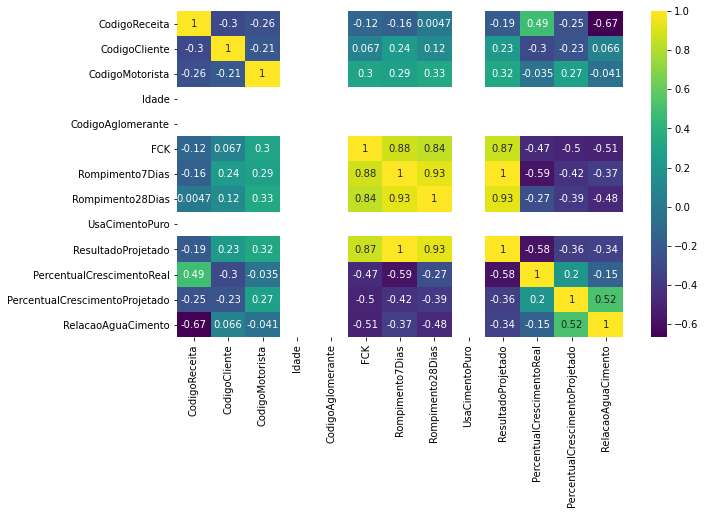

In [136]:
features_numericas = dados_da.select_dtypes(include=['int', 'float'])

k = features_numericas.shape[1] #number of variables for heatmap
cols = dados_da.corr().index
cm = dados_da[cols].corr()
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, cmap = 'viridis')

In [137]:
dados_da.head()

,CodigoReceita,TipoLancamento,DataEmissaoNotaFiscal,CodigoCliente,CodigoMotorista,TempoPermanenciaObra,Idade,TipoTraco,CodigoAglomerante,FCK,Rompimento7Dias,Rompimento28Dias,UsaCimentoPuro,ResultadoProjetado,PercentualCrescimentoReal,PercentualCrescimentoProjetado,RelacaoAguaCimento,DataProjecao
47841,12645051,B,2019-04-29 16:09:14.163,87878998,92079,00:30:00,28,N,17051.0,30.0,28.67,37.59,1,40.944186,31.112661,42.811951,0.571429,2019-05-03
48007,5749051,C,2019-05-03 12:30:28.247,854896998,49080,01:15:00,28,N,17051.0,30.0,34.54,42.62,1,47.981839,23.393167,38.916732,0.561798,2019-05-03
47843,12645051,B,2019-04-30 15:15:25.020,50467998,399051,00:18:00,28,N,17051.0,30.0,32.46,42.47,1,46.229004,30.837954,42.418373,0.568132,2019-05-03
47842,12645051,B,2019-04-30 11:53:26.733,50467998,340051,00:28:00,28,N,17051.0,30.0,32.04,43.79,1,45.644074,36.672909,42.459657,0.571429,2019-05-03
48004,42834051,B,2019-05-03 07:04:18.073,81763998,11148,00:53:00,28,E,17051.0,30.0,30.88,40.35,1,43.052097,30.667098,39.417414,0.498471,2019-05-03


In [138]:
fig = px.box(dados_da, x="TempoPermanenciaObra", title='FCK x Percentual Crescimento')
fig.update_xaxes(categoryorder='category ascending')
fig.show()

In [139]:
def ClassificarTempoPermanenciaObra(item):
    if (item["TempoPermanenciaObra"] <= '00:30:00'):
        return 1
    elif (item["TempoPermanenciaObra"] <= '01:00:00'):
        return 2
    elif (item["TempoPermanenciaObra"] <= '01:30:00'):
        return 3
    elif (item["TempoPermanenciaObra"] <= '02:00:00'):
        return 4
    else:
        return 5

In [140]:
#da["ClassificacaoTempoPermanenciaObra"] = da.apply(ClassificarTempoPermanenciaObra, axis = "columns")

In [157]:
dados_finais = dados_da[["CodigoReceita", "TipoLancamento", "TipoTraco", "FCK", "RelacaoAguaCimento", "Rompimento7Dias", "PercentualCrescimentoReal"]]
dados_finais_teste = dados_teste[["CodigoReceita", "TipoLancamento", "TipoTraco", "FCK", "RelacaoAguaCimento", "Rompimento7Dias", "PercentualCrescimentoReal"]]

In [158]:
dados_finais["TipoLancamento"].replace('C', 0, inplace = True)
dados_finais["TipoLancamento"].replace('B', 1, inplace = True)

dados_finais_teste["TipoLancamento"].replace('C', 0, inplace = True)
dados_finais_teste["TipoLancamento"].replace('B', 1, inplace = True)

dados_finais["TipoTraco"].replace('N', 0, inplace = True)
dados_finais["TipoTraco"].replace('E', 1, inplace = True)

dados_finais_teste["TipoTraco"].replace('N', 0, inplace = True)
dados_finais_teste["TipoTraco"].replace('E', 1, inplace = True)

/home/marina/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [159]:
dados_finais.columns = ['CodigoReceita', 'EhLancamentoBombeavel', 'EhTracoEspecial', 'FCK', 'RelacaoAguaCimento',
       'Rompimento7Dias', 'PercentualCrescimentoReal']

dados_finais_teste.columns = ['CodigoReceita', 'EhLancamentoBombeavel', 'EhTracoEspecial', 'FCK', 'RelacaoAguaCimento',
       'Rompimento7Dias', 'PercentualCrescimentoReal']

In [160]:
dados_finais.head()

,CodigoReceita,EhLancamentoBombeavel,EhTracoEspecial,FCK,RelacaoAguaCimento,Rompimento7Dias,PercentualCrescimentoReal
47841,12645051,1,0,30.0,0.571429,28.67,31.112661
48007,5749051,0,0,30.0,0.561798,34.54,23.393167
47843,12645051,1,0,30.0,0.568132,32.46,30.837954
47842,12645051,1,0,30.0,0.571429,32.04,36.672909
48004,42834051,1,1,30.0,0.498471,30.88,30.667098


In [161]:
dados_finais.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22 entries, 47841 to 48368
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   CodigoReceita              22 non-null     int64  
 1   EhLancamentoBombeavel      22 non-null     int64  
 2   EhTracoEspecial            22 non-null     int64  
 3   FCK                        22 non-null     float64
 4   RelacaoAguaCimento         22 non-null     float64
 5   Rompimento7Dias            22 non-null     float64
 6   PercentualCrescimentoReal  22 non-null     float64
dtypes: float64(4), int64(3)
memory usage: 1.4 KB


In [162]:
class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):        
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class Debug(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):        
        print(X)

modelo = Pipeline([
  ('features', FeatureUnion(
      transformer_list=[
          ('numericals', Pipeline([
              ('selector', TypeSelector(np.number)),
              ('scaler', MinMaxScaler())
          ]))
      ]
  )),
  ('model', GradientBoostingRegressor())
])

In [163]:
x_train = dados_finais.drop("PercentualCrescimentoReal", axis=1)
y_train = dados_finais["PercentualCrescimentoReal"]

x_test = dados_finais_teste.drop("PercentualCrescimentoReal", axis=1)
y_test = dados_finais_teste["PercentualCrescimentoReal"]

#x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state = 123)
modelo.fit(x_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numericals',
                                                 Pipeline(steps=[('selector',
                                                                  TypeSelector(dtype=<class 'numpy.number'>)),
                                                                 ('scaler',
                                                                  MinMaxScaler())]))])),
                ('model', GradientBoostingRegressor())])

In [164]:
y_pred = modelo.predict(x_test)

In [165]:
dados_teste = da.loc[y_test.index]
y_proj = dados_teste["PercentualCrescimentoProjetado"]

In [166]:
j = 0

resultado_final_arvore = []

for i in y_test.index:
    diff_real_proj = (y_test[i] - y_proj[i])/y_test[i]
    diff_real_pred = (y_test[i] - y_pred[j])/y_test[i]
    
    if (diff_real_proj <= diff_real_pred):
        resultado_final_arvore.append('ModeloAntigo')
    else:
        resultado_final_arvore.append('ModeloNovo')
        
    j = j + 1

In [167]:
resultado_final_arvore.count('ModeloNovo')

29

In [168]:
resultado_final_arvore.count('ModeloAntigo')

2

In [169]:
resultado_final_arvore.count('ModeloNovo') / (resultado_final_arvore.count('ModeloNovo') + resultado_final_arvore.count('ModeloAntigo'))

0.9354838709677419